In [16]:
##### base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# matplotlib
%matplotlib inline

# display
from IPython.display import display

# autoreload
%load_ext autoreload
%autoreload 2

# warnings
import warnings
warnings.filterwarnings('ignore')

# fix random seed
from numpy.random import seed as set_random_seed
set_random_seed(42)

# explainability
import shap, lime #eli5
shap.initjs()

# debug
from icecream import ic
debug = ic


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
debug.disable() # ['enable' , 'disable']

# Data

## Load raw articles

In [3]:
from data_extraction.articles import get_articles
articles_processed = get_articles(processed=True)
articles_processed.sample().iloc[0]

main_title                 מוקש אחרון לפני ממשלת נתניהו מול בנט
sub_title     רה , עשוי לכהן גם שר חוץ בעקבות החלטת ליברמן ,...
content       ה קרב אחרון דרך הקמת ממשלה פחות יומיים נותרו ע...
Name: https://www.ynet.co.il/articles/0,7340,L-4653756,00.html, dtype: object

In [4]:
print(articles_processed.shape)
for col in articles_processed.columns:
    articles_processed = articles_processed[articles_processed[col].str.len() > 0]
print(articles_processed.shape)

(1801, 3)
(1791, 3)


In [13]:
# articles_processed['main_title'].apply(print)

### Test extraction possibility

In [6]:
articles_processed.sample(10).apply(lambda r:
    [(r['content'].split().index(word) if word in r['content'].split() else -1) for word in r['main_title'].split()]
                        , axis = 1)

https://www.ynet.co.il/articles/0,7340,L-3794106,00.html                              [6, 46, 44, -1, 4]
https://www.ynet.co.il/articles/0,7340,L-5422317,00.html     [-1, 363, 218, 56, 220, 125, -1, 56, 6, 92]
https://www.ynet.co.il/articles/0,7340,L-2876324,00.html                  [-1, 1, 2, 38, -1, -1, 69, 70]
https://www.ynet.co.il/articles/0,7340,L-3180863,00.html                         [4, -1, 23, 41, 42, -1]
https://www.ynet.co.il/articles/0,7340,L-4671191,00.html    [19, -1, -1, 52, 53, 54, 55, 44, -1, -1, 65]
https://www.ynet.co.il/articles/0,7340,L-3168704,00.html                  [-1, 9, 10, -1, -1, 16, -1, 7]
https://www.ynet.co.il/articles/0,7340,L-3352560,00.html                  [19, 0, -1, 32, 5, -1, 25, 31]
https://www.ynet.co.il/articles/0,7340,L-3325330,00.html                      [8, 13, 49, 39, 51, 53, 3]
https://www.ynet.co.il/articles/0,7340,L-2990368,00.html                 [4, -1, 79, 11, 14, -1, 51, 52]
https://www.ynet.co.il/articles/0,7340,L-4663434,00.htm

In [7]:
articles_processed.apply(lambda r:
    [(r['content'].split().index(word) if word in r['content'].split() else -1) for word in r['sub_title'].split()]
                        , axis = 1)

https://www.ynet.co.il/articles/0,7340,L-4633999,00.html    [0, 1, 2, 9, 10, 11, 151, -1, -1, -1, 148, 149...
https://www.ynet.co.il/news/article/r1B28Y00H00             [-1, -1, 10, 84, -1, -1, 13, 14, 42, 50, 51, 6...
https://www.ynet.co.il/news/article/BJoi3v31v               [72, -1, -1, 25, 12, 27, 28, 19, 78, 129, 72, ...
https://www.ynet.co.il/articles/0,7340,L-5752518,00.html    [4, -1, 1, 2, 66, 11, 13, 14, 15, 16, 146, 18,...
https://www.ynet.co.il/articles/0,7340,L-4254657,00.html    [26, 27, 28, 29, -1, 135, 13, 14, 15, -1, 2, -...
                                                                                  ...                        
https://www.ynet.co.il/articles/0,7340,L-3326873,00.html    [-1, 496, 34, 45, 53, 7, 60, 61, 61, 57, 58, 7...
https://www.ynet.co.il/articles/0,7340,L-4331064,00.html    [-1, -1, -1, 25, 16, 0, 3, 253, 297, 117, 293,...
https://www.ynet.co.il/articles/0,7340,L-3809650,00.html    [-1, -1, 12, 72, 86, 87, 6, 128, 129, 130, -1,...
https://ww

## Tokenize articles

In [8]:
from spacy.lang.he.stop_words import STOP_WORDS
STOP_WORDS.update(',')

In [9]:
from feature_extraction.article import tokenize_article
articles = articles_processed.apply(tokenize_article, axis = 1, args = [[STOP_WORDS]])

<AxesSubplot:ylabel='Frequency'>

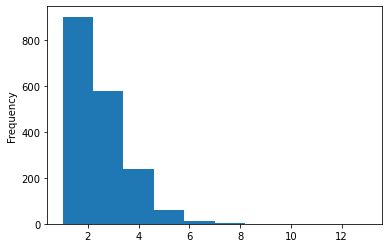

In [10]:
articles['sub_title'].apply(len).plot.hist()

## Merge raw and tokenized

In [11]:
raw_articles = get_articles()

articles_joined = pd.merge(
    articles,
    raw_articles,
    right_index = True,
    left_index = True,
    how = 'inner',
    suffixes= ('', '_raw')
)

# Summarazation

## Init Model

In [18]:
from spacy.lang.he.stop_words import STOP_WORDS
STOP_WORDS.update(',')

In [180]:
from models.nlp.summarization.textrank import TextRankModel
from models.nlp.summarization.firstk import FirstKModel
from models.nlp.summarization.leafnats import LeafNATSModel

model_hyparam = {
            'n_epoch': 35,
            'batch_size': 16,
            'checkpoint': 100,
            'val_num_batch': 30,
            'nbestmodel': 5,#10,
            'continue_training': False,
            'train_base_model': True,
            'use_move_avg': False,
            'use_optimal_model': True,
            'model_optimal_key': '0,0',
            'is_lower': False,
            'device': torch.device("cpu"),
            'file_vocab': 'vocab',
            'max_vocab_size': 50000,
            'word_minfreq': 5,
            'emb_dim': 128,
            'src_hidden_dim': 256,
            'trg_hidden_dim': 256,
            'src_seq_lens': 400,
            'trg_seq_lens': 30,#100,
            'rnn_network': 'lstm',
            'attn_method': 'luong_concat',
            'repetition': 'vanilla',
            'pointer_net': True,
            'oov_explicit': True,
            'attn_decoder': True,
            'share_emb_weight': True,
            'learning_rate': 0.001,#0.0001,
            'grad_clip': 2.0,
            'beam_size': 5,
            'test_batch_size': 1,
            'copy_words': True,
        }
model = LeafNATSModel(STOP_WORDS, **model_hyparam)

In [45]:
data = articles_joined.sample(500)
# data = articles_joined.loc[['https://www.ynet.co.il/articles/0,7340,L-3633770,00.html']]

## Fit

In [181]:
from utils.utils import read_data
data = read_data('data.pickle')
# data = data.sample(50)

In [182]:
import torch


model.fit(
    data['content'],
    y = data['sub_title'].apply(lambda l: l[0])
)

The vocabulary size: 6075
{}
{'embedding': natsEmbedding(
  (embedding): Embedding(6075, 128)
  (proj2vocab): Linear(in_features=128, out_features=6075, bias=True)
), 'encoder': natsEncoder(
  (encoder): LSTM(128, 256, batch_first=True, bidirectional=True)
), 'encoder2decoder': natsEncoder2Decoder(
  (encoder2decoder): Linear(in_features=512, out_features=256, bias=True)
  (encoder2decoder_c): Linear(in_features=512, out_features=256, bias=True)
), 'pgdecoder': PointerGeneratorDecoder(
  (rnn_): LSTMCell(384, 256)
  (encoder_attn_layer): AttentionEncoder(
    (attn_en_in): Linear(in_features=512, out_features=256, bias=True)
    (attn_de_in): Linear(in_features=256, out_features=256, bias=False)
    (attn_cv_in): Linear(in_features=1, out_features=256, bias=False)
    (attn_warp_in): Linear(in_features=256, out_features=1, bias=False)
  )
  (decoder_attn_layer): AttentionDecoder(
    (attn_en_in): Linear(in_features=256, out_features=256, bias=True)
    (attn_de_in): Linear(in_features

epoch=1, batch=30, loss=9.496402740478516, time_escape=247.94557332992554s=0.06887377036942376h
NATS Message: 
epoch=1, batch=31, loss=9.216546058654785, time_escape=249.81379318237305s=0.06939272032843696h
NATS Message: 
The number of batches: 32
epoch=2, batch=0, loss=8.347057342529297, time_escape=253.6331000328064s=0.07045363889800178h
NATS Message: 
epoch=2, batch=1, loss=8.974676132202148, time_escape=257.42075061798096s=0.07150576406055027h
NATS Message: 
epoch=2, batch=2, loss=8.802969932556152, time_escape=261.40825033187866s=0.0726134028699663h
NATS Message: 
epoch=2, batch=3, loss=8.71855640411377, time_escape=265.5846471786499s=0.07377351310518053h
NATS Message: 
epoch=2, batch=4, loss=8.037712097167969, time_escape=269.8198490142822s=0.07494995805952284h
NATS Message: 
epoch=2, batch=5, loss=10.316307067871094, time_escape=274.550669670105s=0.0762640749083625h
NATS Message: 
epoch=2, batch=6, loss=8.780877113342285, time_escape=278.42042446136475s=0.07733900679482354h
NATS

epoch=4, batch=8, loss=7.1227006912231445, time_escape=515.5647778511047s=0.14321243829197353h
NATS Message: 
epoch=4, batch=9, loss=8.058431625366211, time_escape=519.1943864822388s=0.144220662911733h
NATS Message: 
epoch=4, batch=10, loss=7.872842788696289, time_escape=523.861227273941s=0.14551700757609473h
NATS Message: 
epoch=4, batch=11, loss=8.304929733276367, time_escape=528.1012344360352s=0.1466947873433431h
NATS Message: 
epoch=4, batch=12, loss=8.285078048706055, time_escape=532.5302531719208s=0.14792507032553354h
NATS Message: 
epoch=4, batch=13, loss=7.932249069213867, time_escape=536.0592205524445s=0.14890533904234568h
NATS Message: 
epoch=4, batch=14, loss=7.885287284851074, time_escape=539.888799905777s=0.14996911108493804h
NATS Message: 
epoch=4, batch=15, loss=7.963475227355957, time_escape=543.2335987091064s=0.15089822186364069h
NATS Message: 
epoch=4, batch=16, loss=7.154497146606445, time_escape=546.7546563148499s=0.15187629342079162h
NATS Message: 
epoch=4, batch=1

epoch=6, batch=19, loss=6.559488773345947, time_escape=794.8883016109467s=0.22080230600304074h
NATS Message: 
epoch=6, batch=20, loss=7.323526382446289, time_escape=798.5544266700745s=0.22182067407502068h
NATS Message: 
epoch=6, batch=21, loss=6.280236721038818, time_escape=802.177482843399s=0.22282707856761086h
NATS Message: 
epoch=6, batch=22, loss=7.506900310516357, time_escape=805.8519518375397s=0.22384776439931658h
NATS Message: 
epoch=6, batch=23, loss=6.264366626739502, time_escape=809.5669782161713s=0.22487971617115868h
NATS Message: 
epoch=6, batch=24, loss=7.387990951538086, time_escape=813.2888145446777s=0.2259135595957438h
NATS Message: 
epoch=6, batch=25, loss=7.99872350692749, time_escape=816.9816300868988s=0.22693934169080524h
NATS Message: 
epoch=6, batch=26, loss=6.502645969390869, time_escape=820.6493573188782s=0.22795815481079948h
NATS Message: 
epoch=6, batch=27, loss=6.841413497924805, time_escape=824.3326683044434s=0.22898129675123427h
NATS Message: 
epoch=6, batc

epoch=8, batch=30, loss=6.199365139007568, time_escape=1077.3046181201935s=0.29925128281116486h
NATS Message: 
epoch=8, batch=31, loss=6.169739246368408, time_escape=1079.3542590141296s=0.2998206275039249h
NATS Message: 
The number of batches: 32
epoch=9, batch=0, loss=5.415178298950195, time_escape=1083.2469809055328s=0.3009019391404258h
NATS Message: 
epoch=9, batch=1, loss=4.65500545501709, time_escape=1086.9303305149078s=0.3019250918096966h
NATS Message: 
epoch=9, batch=2, loss=4.59401798248291, time_escape=1090.6693260669708s=0.30296370168526965h
NATS Message: 
epoch=9, batch=3, loss=4.961565017700195, time_escape=1094.3215341567993s=0.30397820393244424h
NATS Message: 
epoch=9, batch=4, loss=5.944730758666992, time_escape=1098.0802471637726s=0.3050222908788257h
NATS Message: 
epoch=9, batch=5, loss=5.074779987335205, time_escape=1101.803813457489s=0.3060566148493025h
NATS Message: 
epoch=9, batch=6, loss=5.789546012878418, time_escape=1105.5039811134338s=0.3070844391981761h
NATS M

epoch=11, batch=8, loss=4.460697174072266, time_escape=1369.6639306545258s=0.3804622029595905h
NATS Message: 
epoch=11, batch=9, loss=5.1477556228637695, time_escape=1373.4338972568512s=0.3815094159046809h
NATS Message: 
epoch=11, batch=10, loss=4.283059597015381, time_escape=1377.6178984642029s=0.3826716384622786h
NATS Message: 
epoch=11, batch=11, loss=5.207194805145264, time_escape=1382.139895915985s=0.3839277488655514h
NATS Message: 
epoch=11, batch=12, loss=5.420537948608398, time_escape=1386.2898979187012s=0.3850805271996392h
NATS Message: 
epoch=11, batch=13, loss=3.920942544937134, time_escape=1390.2417433261871s=0.38617826203505196h
NATS Message: 
epoch=11, batch=14, loss=4.479806900024414, time_escape=1393.9307901859283s=0.387202997273869h
NATS Message: 
epoch=11, batch=15, loss=5.604635238647461, time_escape=1398.1057908535004s=0.38836271968152786h
NATS Message: 
epoch=11, batch=16, loss=5.108839988708496, time_escape=1402.3617942333221s=0.3895449428425895h
NATS Message: 
ep

epoch=13, batch=18, loss=4.601750373840332, time_escape=1695.5291979312897s=0.47098033275869156h
NATS Message: 
epoch=13, batch=19, loss=4.062106132507324, time_escape=1699.9660058021545s=0.47221277938948736h
NATS Message: 
epoch=13, batch=20, loss=5.018004417419434, time_escape=1704.6713690757751s=0.47351982474327087h
NATS Message: 
epoch=13, batch=21, loss=4.132112503051758, time_escape=1709.2048048973083s=0.47477911247147453h
NATS Message: 
epoch=13, batch=22, loss=3.404913902282715, time_escape=1713.594357252121s=0.4759984325700336h
NATS Message: 
epoch=13, batch=23, loss=3.568995475769043, time_escape=1718.2008731365204s=0.4772780203157001h
NATS Message: 
epoch=13, batch=24, loss=3.821676015853882, time_escape=1722.6588625907898s=0.4785163507196638h
NATS Message: 
epoch=13, batch=25, loss=3.6637070178985596, time_escape=1727.2723801136017s=0.4797978833648894h
NATS Message: 
epoch=13, batch=26, loss=3.9811813831329346, time_escape=1731.719144821167s=0.4810330957836575h
NATS Message

epoch=15, batch=28, loss=2.744992971420288, time_escape=1994.1622149944305s=0.553933948609564h
NATS Message: 
epoch=15, batch=29, loss=3.216203451156616, time_escape=1998.0165572166443s=0.5550045992268456h
NATS Message: 
epoch=15, batch=30, loss=3.2677693367004395, time_escape=2001.5152688026428s=0.5559764635562897h
NATS Message: 
epoch=15, batch=31, loss=6.483903884887695, time_escape=2003.271163225174s=0.5564642120069928h
NATS Message: 
The number of batches: 32
epoch=16, batch=0, loss=4.122725963592529, time_escape=2006.932438135147s=0.5574812328153186h
NATS Message: 
epoch=16, batch=1, loss=2.626958131790161, time_escape=2010.4868302345276s=0.5584685639540354h
NATS Message: 
epoch=16, batch=2, loss=3.4395639896392822, time_escape=2013.9311425685883s=0.5594253173801634h
NATS Message: 
epoch=16, batch=3, loss=3.23984432220459, time_escape=2017.4191391468048s=0.5603942053185569h
NATS Message: 
epoch=16, batch=4, loss=3.471140146255493, time_escape=2021.1290299892426s=0.561424730552567

epoch=18, batch=6, loss=3.1636743545532227, time_escape=2295.2340483665466s=0.6375650134351518h
NATS Message: 
epoch=18, batch=7, loss=3.797851800918579, time_escape=2298.8019325733185s=0.6385560923814774h
NATS Message: 
epoch=18, batch=8, loss=2.3940317630767822, time_escape=2302.3188495635986s=0.6395330137676662h
NATS Message: 
epoch=18, batch=9, loss=3.6099791526794434, time_escape=2305.821981191635s=0.6405061058865653h
NATS Message: 
epoch=18, batch=10, loss=3.3840529918670654, time_escape=2309.3255484104156s=0.6414793190028932h
NATS Message: 
epoch=18, batch=11, loss=2.8011999130249023, time_escape=2312.902586221695s=0.6424729406171374h
NATS Message: 
epoch=18, batch=12, loss=3.4945781230926514, time_escape=2316.353350877762s=0.6434314863549339h
NATS Message: 
epoch=18, batch=13, loss=4.262933254241943, time_escape=2320.394758939743s=0.6445540997054842h
NATS Message: 
epoch=18, batch=14, loss=4.49813985824585, time_escape=2324.3214149475098s=0.6456448374854193h
NATS Message: 
epoc

epoch=20, batch=16, loss=3.669560670852661, time_escape=2574.6566677093506s=0.7151824076970418h
NATS Message: 
epoch=20, batch=17, loss=3.652775526046753, time_escape=2578.2186319828033s=0.7161718422174453h
NATS Message: 
epoch=20, batch=18, loss=3.23233962059021, time_escape=2581.958405017853s=0.7172106680605147h
NATS Message: 
epoch=20, batch=19, loss=4.952910900115967, time_escape=2585.4739854335785s=0.7181872181759941h
NATS Message: 
epoch=20, batch=20, loss=3.2836151123046875, time_escape=2589.035348892212s=0.7191764858033922h
NATS Message: 
epoch=20, batch=21, loss=2.9727320671081543, time_escape=2592.596804380417s=0.7201657789945602h
NATS Message: 
epoch=20, batch=22, loss=3.356982946395874, time_escape=2596.1338763237s=0.7211482989788055h
NATS Message: 
epoch=20, batch=23, loss=3.385258674621582, time_escape=2599.6454203128815s=0.7221237278646893h
NATS Message: 
epoch=20, batch=24, loss=4.693402290344238, time_escape=2603.392526626587s=0.7231645907296075h
NATS Message: 
epoch=2

epoch=22, batch=26, loss=3.0894670486450195, time_escape=2859.035493850708s=0.7941765260696411h
NATS Message: 
epoch=22, batch=27, loss=3.4279727935791016, time_escape=2862.5885195732117s=0.7951634776592255h
NATS Message: 
epoch=22, batch=28, loss=3.5486154556274414, time_escape=2866.195475578308s=0.7961654098828633h
NATS Message: 
epoch=22, batch=29, loss=5.0612406730651855, time_escape=2870.0552310943604s=0.7972375641928778h
NATS Message: 
epoch=22, batch=30, loss=3.433168411254883, time_escape=2873.9249320030212s=0.7983124811119503h
NATS Message: 
epoch=22, batch=31, loss=3.11299729347229, time_escape=2875.720455646515s=0.7988112376795875h
NATS Message: 
The number of batches: 32
epoch=23, batch=0, loss=3.493910074234009, time_escape=2879.505730867386s=0.7998627030187183h
NATS Message: 
epoch=23, batch=1, loss=3.074608564376831, time_escape=2883.1148159503937s=0.8008652266528872h
NATS Message: 
epoch=23, batch=2, loss=3.732733726501465, time_escape=2886.6579139232635s=0.801849420534

epoch=25, batch=4, loss=3.4051625728607178, time_escape=3138.2866904735565s=0.8717463029093212h
NATS Message: 
epoch=25, batch=5, loss=4.470502853393555, time_escape=3141.8482542037964s=0.8727356261677213h
NATS Message: 
epoch=25, batch=6, loss=3.7562336921691895, time_escape=3145.5397996902466s=0.873761055469513h
NATS Message: 
epoch=25, batch=7, loss=2.6048319339752197, time_escape=3149.1349201202393s=0.8747597000333998h
NATS Message: 
epoch=25, batch=8, loss=3.2536873817443848, time_escape=3152.7700123786926s=0.8757694478829702h
NATS Message: 
epoch=25, batch=9, loss=3.2894301414489746, time_escape=3156.5181682109833s=0.8768106022808286h
NATS Message: 
epoch=25, batch=10, loss=3.0375266075134277, time_escape=3160.1154325008392s=0.8778098423613442h
NATS Message: 
epoch=25, batch=11, loss=2.451873779296875, time_escape=3164.6211800575256s=0.8790614389048682h
NATS Message: 
epoch=25, batch=12, loss=2.349841356277466, time_escape=3168.7019793987274s=0.8801949942774243h
NATS Message: 
ep

epoch=27, batch=14, loss=4.373055458068848, time_escape=3439.9133265018463s=0.9555314795838462h
NATS Message: 
epoch=27, batch=15, loss=1.935563564300537, time_escape=3443.9695751667023s=0.956658215324084h
NATS Message: 
epoch=27, batch=16, loss=2.767423152923584, time_escape=3448.047470331192s=0.9577909639808867h
NATS Message: 
epoch=27, batch=17, loss=2.524768590927124, time_escape=3452.0844707489014s=0.9589123529858059h
NATS Message: 
epoch=27, batch=18, loss=3.986879587173462, time_escape=3456.222078561783s=0.9600616884893841h
NATS Message: 
epoch=27, batch=19, loss=3.428849220275879, time_escape=3460.259963274002s=0.9611833231316672h
NATS Message: 
epoch=27, batch=20, loss=3.6695375442504883, time_escape=3464.3502621650696s=0.9623195172680749h
NATS Message: 
epoch=27, batch=21, loss=4.413638591766357, time_escape=3469.3633654117584s=0.9637120459477106h
NATS Message: 
epoch=27, batch=22, loss=3.026369333267212, time_escape=3474.0983691215515s=0.9650273247559865h
NATS Message: 
epoc

epoch=29, batch=24, loss=2.981555700302124, time_escape=3741.2150967121124s=1.0392264157533646h
NATS Message: 
epoch=29, batch=25, loss=2.800515651702881, time_escape=3745.2346131801605s=1.0403429481056001h
NATS Message: 
epoch=29, batch=26, loss=3.211794137954712, time_escape=3749.6953876018524s=1.0415820521116257h
NATS Message: 
epoch=29, batch=27, loss=3.406240701675415, time_escape=3753.9033885002136s=1.0427509412500593h
NATS Message: 
epoch=29, batch=28, loss=3.883718967437744, time_escape=3759.9026033878326s=1.0444173898299536h
NATS Message: 
epoch=29, batch=29, loss=3.462254524230957, time_escape=3764.8826038837433s=1.0458007233010398h
NATS Message: 
epoch=29, batch=30, loss=5.056347846984863, time_escape=3770.0541002750397s=1.0472372500764h
NATS Message: 
epoch=29, batch=31, loss=3.268791437149048, time_escape=3771.951619386673s=1.0477643387185203h
NATS Message: 
The number of batches: 32
epoch=30, batch=0, loss=3.6660594940185547, time_escape=3776.36962223053s=1.04899156173070

epoch=32, batch=2, loss=2.0442092418670654, time_escape=4028.2370100021362s=1.1189547250005933h
NATS Message: 
epoch=32, batch=3, loss=2.729295492172241, time_escape=4031.770196914673s=1.1199361658096314h
NATS Message: 
epoch=32, batch=4, loss=3.334139108657837, time_escape=4035.67711853981s=1.121021421816614h
NATS Message: 
epoch=32, batch=5, loss=3.3449649810791016, time_escape=4039.2992238998413s=1.1220275621944005h
NATS Message: 
epoch=32, batch=6, loss=2.840531349182129, time_escape=4042.7196764945984s=1.1229776879151663h
NATS Message: 
epoch=32, batch=7, loss=3.0629796981811523, time_escape=4046.1710183620453s=1.123936393989457h
NATS Message: 
epoch=32, batch=8, loss=2.9262726306915283, time_escape=4049.8568868637085s=1.1249602463510302h
NATS Message: 
epoch=32, batch=9, loss=3.4331493377685547, time_escape=4053.372073173523s=1.1259366869926453h
NATS Message: 
epoch=32, batch=10, loss=3.4251370429992676, time_escape=4056.7028810977936s=1.1268619114160539h
NATS Message: 
epoch=32,

epoch=34, batch=12, loss=2.115509510040283, time_escape=4301.118542671204s=1.194755150742001h
NATS Message: 
epoch=34, batch=13, loss=4.891321182250977, time_escape=4305.075536251068s=1.1958543156252968h
NATS Message: 
epoch=34, batch=14, loss=2.753100872039795, time_escape=4308.9875745773315s=1.1969409929381476h
NATS Message: 
epoch=34, batch=15, loss=2.624418020248413, time_escape=4313.289832115173s=1.198136064476437h
NATS Message: 
epoch=34, batch=16, loss=3.5214312076568604, time_escape=4317.105308294296s=1.1991959189706378h
NATS Message: 
epoch=34, batch=17, loss=2.8155791759490967, time_escape=4320.6822118759155s=1.2001895032988654h
NATS Message: 
epoch=34, batch=18, loss=2.8476860523223877, time_escape=4324.3732817173s=1.201214800477028h
NATS Message: 
epoch=34, batch=19, loss=3.105405569076538, time_escape=4328.018508672714s=1.2022273635201983h
NATS Message: 
epoch=34, batch=20, loss=3.448626756668091, time_escape=4331.4174015522s=1.2031715004311667h
NATS Message: 
epoch=34, ba

## Predict

In [187]:
summaries = model.predict(
    data['content'].sample(2),
#     data['content_raw']
)

The vocabulary size: 6075
{}
{'decoder2proj': Linear(in_features=256, out_features=128, bias=False),
 'embedding': natsEmbedding(
  (embedding): Embedding(6075, 128)
  (proj2vocab): Linear(in_features=128, out_features=6075, bias=True)
),
 'encoder': natsEncoder(
  (encoder): LSTM(128, 256, batch_first=True, bidirectional=True)
),
 'encoder2decoder': natsEncoder2Decoder(
  (encoder2decoder): Linear(in_features=512, out_features=256, bias=True)
  (encoder2decoder_c): Linear(in_features=512, out_features=256, bias=True)
),
 'pgdecoder': PointerGeneratorDecoder(
  (rnn_): LSTMCell(384, 256)
  (encoder_attn_layer): AttentionEncoder(
    (attn_en_in): Linear(in_features=512, out_features=256, bias=True)
    (attn_de_in): Linear(in_features=256, out_features=256, bias=False)
    (attn_cv_in): Linear(in_features=1, out_features=256, bias=False)
    (attn_warp_in): Linear(in_features=256, out_features=1, bias=False)
  )
  (decoder_attn_layer): AttentionDecoder(
    (attn_en_in): Linear(in_feat

In [188]:
summaries

,summary_tokens,summary
"https://www.ynet.co.il/articles/0,7340,L-4328047,00.html","[אחרי, בחירות, עולה, ימין, יושב, הערב, יום, על...",אחרי בחירות עולה ימין יושב הערב יום על משטרה ה...
"https://www.ynet.co.il/articles/0,7340,L-4131069,00.html","[אחרי, בחירות, עולה, ימין, יושב, הערב, יום, על...",אחרי בחירות עולה ימין יושב הערב יום על משטרה ה...


In [83]:
data = pd.merge(
    data,
    summaries,
    right_index = True,
    left_index = True,
    how = 'inner',
    suffixes= ('', '')
)

In [84]:
data.iloc[1][['sub_title', 'summary', 'content']].apply(print)

[['ה', 'הבנה', 'סיכויי', 'הצלחת', 'ערעור', 'תיק', 'קלושים', 'הכריעה'], ['וינשטיין', 'הדגיש', 'החלטה', 'אין', 'כדי', 'לתת', 'הכשר', 'מעשי', 'ליברמן', ',', 'גם', 'בית', 'משפט', 'מצא', 'אינם', 'ראויים', ',', 'אינם', 'מוסריים', 'אינם', 'עומדים', 'סטנדרט', 'מצופה', 'מאיש', 'ציבור']]
ועדת שרים ענייני חקיקה אישרה היום נגד הצעת חוק לפי היא בין מסקנות גביר את היא ביטוח מסקנות גביר שכר , אחר צהריים יום את נפגעים </s> <s> אחר צהריים
[['ה', 'יועץ', 'משפטי', 'ממשלה', 'יהודה', 'וינשטיין', 'הודיע', 'צהריים', 'יום', 'כי', 'לא', 'יערער', 'על', 'זיכויו', 'של', 'אביגדור', 'ליברמן', 'פרשת', 'שגריר'], ['וינשטיין', 'סבר', 'יש', 'טעויות', 'קביעות', 'לא', 'נכונות', 'הכרעת', 'דין', ',', 'אך', 'נגד', 'הכריעה', 'הבנה', 'סיכויי', 'הצלחת', 'ערעור', 'תיק', 'קלושים'], ['הוא', 'מתח', 'ביקורת', 'על', 'מעשיו', 'של', 'ליברמן'], ['בית', 'משפט', 'שלום', 'ירושלים', 'זיכה', 'את', 'ליברמן', 'חודש', 'עבר', ',', 'אחרי', 'יותר', 'עשור', 'של', 'חקירה'], ['הוא', 'הואשם', 'מרמה', 'הפרת', 'אמונים', 'פרשת', 'מינויו', 'של', 'שגריר', 

sub_title    None
summary      None
content      None
Name: https://www.ynet.co.il/articles/0,7340,L-4466154,00.html, dtype: object

# Evaluation

In [86]:
from utils.metric_utils import jaccard_score, bleu, rouge

def check_score(r, score = jaccard_score, *score_args, **score_kwargs):
    summary = r['summary_tokens']
    sub_title = r['sub_title']
    return score(sub_title[0], summary, *score_args, **score_kwargs)
scores = data.apply(check_score, axis = 1, args = (bleu, 1))
data['score'] = scores

0.13099692049247708
ביום המאבק הבינלאומי למניעת אלימות נגד נשים ביקר ראש הממשלה במעון לנשים מוכות: "החובה שלנו היא לתת לכן חיים של כבוד, ביטחון ופרנסה. אנחנו לא מוותרים עליכן, אתן אל תוותרו על עצמכן". דו"ח ויצו: כ-60 נשים לא נכנסו השנה למעונות עקב מחסור במקום פנוי
ועדת שרים ענייני חקיקה אישרה היום נגד הצעת חוק לפי היא בין מסקנות גביר את היא ביטוח מסקנות גביר שכר , אחר צהריים יום את נפגעים </s> <s> אחר צהריים
0.1263898051634325
יו"ר מפלגת מגן תקף את רשימת כחול לבן: "תכליתה היא החלפת השלטון ואחר כך יישבו על פיסטוקים ויחליטו לאן לקחת את המדינה". הוא תקף גם את מפלגת כולנו: "היא לא מפלגה" וטען שייכנס לכנסת "למרות שלא סוקרים אותנו"
ועדת שרים ענייני חקיקה אישרה היום נגד הצעת חוק לפי היא בין מסקנות גביר את היא ביטוח מסקנות גביר שכר , אחר צהריים יום את נפגעים </s> <s> אחר צהריים
0.09735009788392564
בנו של ראש הממשלה אמר: "הוא רואה את המראות שכולנו רואים, החייזרים האלה בהפגנות, זה מצחיק אותו, זה כמו בידור". לאחר מכן ניסה להסביר: "התכוונתי לאלה שמתחפשים לחייזרים ועב"מים"
ועדת שרים ענייני חקיקה אי

(array([10.,  4., 15.,  2., 11.,  2.,  1.,  3.,  0.,  2.]),
 array([0.        , 0.01309969, 0.02619938, 0.03929908, 0.05239877,
        0.06549846, 0.07859815, 0.09169784, 0.10479754, 0.11789723,
        0.13099692]),
 <BarContainer object of 10 artists>)

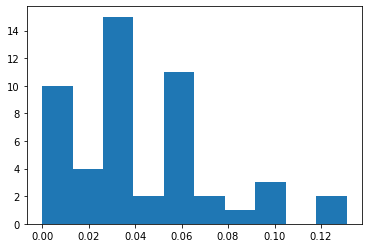

In [88]:
data.sort_values('score', ascending=False).head()[['score', 'sub_title_raw', 'summary']].apply(lambda r: r.apply(print), axis = 1)
plt.hist(scores)

In [89]:
scores.mean()

0.041730989572469436

# Compare between Algorithms

In [184]:
test = data.sample(50)

In [189]:
def compare_models(models: dict, metrics: dict, train, test, fit = False, plot = False):
    summaries_pred = {}
    scores_table = {}
    for model_name, model in models.items():
        if fit:
            model.fit(
                train['content'],
                train['content_raw'],
                y = train['sub_title'].apply(lambda l: l[0]),
            )
        summaries_pred[model_name] = model.predict(
            test['content'],
            test['content_raw']
        )
        scores_table[model_name] = {}
    for metric_name, metric_args in metrics.items():
        for model_name, model in models.items():
            data = test.copy(deep=True)
            data = pd.merge(
                data,
                summaries_pred[model_name],
                right_index = True,
                left_index = True,
                how = 'inner',
                suffixes= ('', '')
            )
            scores = data.apply(check_score, axis = 1, args = metric_args)
            score_mean = np.round(scores.mean(), 2)
            if plot:
                plt.hist(scores, label = f'{model_name}: {score_mean}', alpha = 1.5 * (1/len(models.keys())))
            scores_table[model_name][metric_name] = score_mean
        if plot:
            plt.title(f'Hisogram for {metric_name} score')
            plt.legend()
            plt.show()
    return pd.DataFrame(scores_table)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

The vocabulary size: 6075
{}
{'decoder2proj': Linear(in_features=256, out_features=128, bias=False),
 'embedding': natsEmbedding(
  (embedding): Embedding(6075, 128)
  (proj2vocab): Linear(in_features=128, out_features=6075, bias=True)
),
 'encoder': natsEncoder(
  (encoder): LSTM(128, 256, batch_first=True, bidirectional=True)
),
 'encoder2decoder': natsEncoder2Decoder(
  (encoder2decoder): Linear(in_features=512, out_features=256, bias=True)
  (encoder2decoder_c): Linear(in_features=512, out_features=256, bias=True)
),
 'pgdecoder': PointerGeneratorDecoder(
  (rnn_): LSTMCell(384, 256)
  (encoder_attn_layer): AttentionEncoder(
    (attn_en_in): Linear(in_features=512, out_features=256, bias=True)
    (attn_de_in): Linear(in_features=256, out_features=256, bias=False)
    (attn_cv_in): Linear(in_features=1, out_features=256, bias=False)
    (attn_warp_in): Linear(in_features=256, out_features=1, bias=False)
  )
  (decoder_attn_layer): AttentionDecoder(
    (attn_en_in): Linear(in_feat

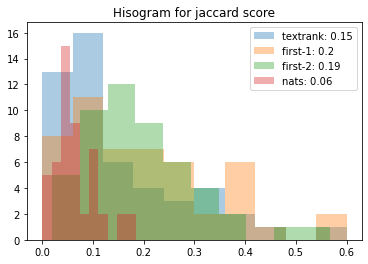

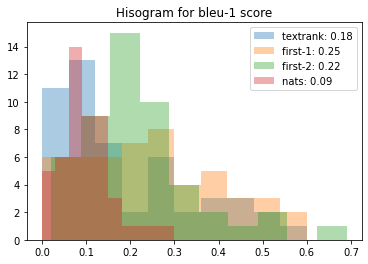

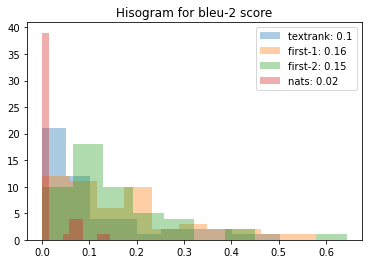

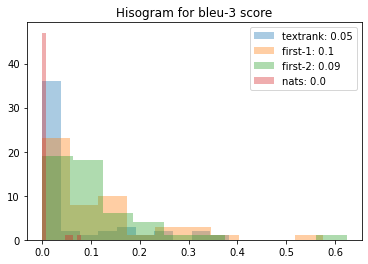

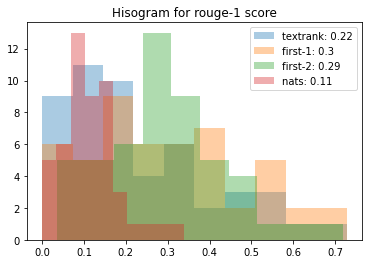

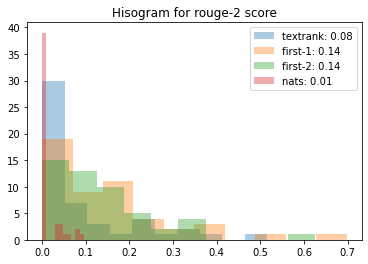

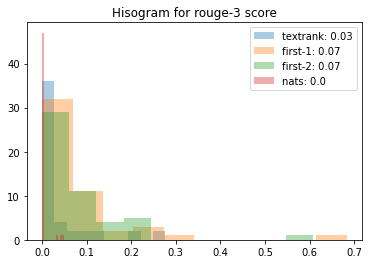

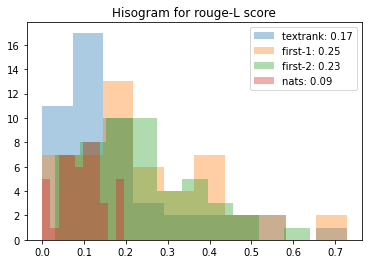

In [191]:
model_hyparam = {
            'n_epoch': 1,
            'batch_size': 16,
            'checkpoint': 100,
            'val_num_batch': 30,
            'nbestmodel': 5,#10,
            'continue_training': True,
            'train_base_model': True,
            'use_move_avg': False,
            'use_optimal_model': True,
            'model_optimal_key': '0,0',
            'is_lower': False,
            'device': torch.device("cpu"),
            'file_vocab': 'vocab',
            'max_vocab_size': 50000,
            'word_minfreq': 5,
            'emb_dim': 128,
            'src_hidden_dim': 256,
            'trg_hidden_dim': 256,
            'src_seq_lens': 400,
            'trg_seq_lens': 30,#100,
            'rnn_network': 'lstm',
            'attn_method': 'luong_concat',
            'repetition': 'vanilla',
            'pointer_net': True,
            'oov_explicit': True,
            'attn_decoder': True,
            'share_emb_weight': True,
            'learning_rate': 0.001,#0.0001,
            'grad_clip': 2.0,
            'beam_size': 5,
            'test_batch_size': 1,
            'copy_words': True,
        }
scores_table = compare_models(
    train = data,
    test = test,
    models = {
        'textrank': TextRankModel(STOP_WORDS),
        'first-1': FirstKModel(STOP_WORDS, k=1),
        'first-2': FirstKModel(STOP_WORDS, k=2),
        'nats': LeafNATSModel(STOP_WORDS, **model_hyparam),
        
    },
    metrics = {
        'jaccard': (jaccard_score,),
        'bleu-1': (bleu, 1),
        'bleu-2': (bleu, 2),
        'bleu-3': (bleu, 3),
        'rouge-1': (rouge, 1),
        'rouge-2': (rouge, 2),
        'rouge-3': (rouge, 3),
        'rouge-L': (rouge, 'L'),
    },
    fit = False,
    plot = True
)

In [192]:
scores_table

,textrank,first-1,first-2,nats
jaccard,0.15,0.20,0.19,0.06
bleu-1,0.18,0.25,0.22,0.09
bleu-2,0.10,0.16,0.15,0.02
bleu-3,0.05,0.10,0.09,0.00
rouge-1,0.22,0.30,0.29,0.11
rouge-2,0.08,0.14,0.14,0.01
rouge-3,0.03,0.07,0.07,0.00
rouge-L,0.17,0.25,0.23,0.09


# Save Article

In [ ]:
# from utils import save_article_example
# save_article_example(article, summary)

# Sandbox/Archive - Abstractive

## Seq2Seq LSTM

In [39]:
articles = articles_processed.apply(tokenize_article, axis = 1)

In [41]:
articles = articles.sample(100)

In [50]:
d = {0}
d.update(set([1,2,1]))
d

{0, 1, 2}

In [60]:
vocab = set()
for i, article in articles.iterrows():
    vocab.update(set(article['main_title']))
    vocab.update(set([j for l in article['sub_title'] for j in l]))
    vocab.update(set([j for l in article['content'] for j in l]))
    break

In [61]:
vocab

{'',
 ',',
 '?',
 'ynet',
 'אביב',
 'אבל',
 'אבן',
 'אגו',
 'אדם',
 'או',
 'אוהבים',
 'אוזר',
 'אוכל',
 'אולי',
 'אולפן',
 'אומר',
 'אומרת',
 'אופוזיציה',
 'אופן',
 'אותו',
 'אז',
 'אזרחי',
 'אזרחיה',
 'אזרחים',
 'אחד',
 'אחוז',
 'אחרונה',
 'אחרונות',
 'אחרונים',
 'אחרות',
 'אחרי',
 'אחרים',
 'אחרת',
 'אי',
 'איזו',
 'איזשהו',
 'איך',
 'אילו',
 'אילן',
 'אילת',
 'אין',
 'אינטרסים',
 'איסוף',
 'אירן',
 'איש',
 'אישיות',
 'אישיים',
 'איתמר',
 'אל',
 'אלה',
 'אלעד',
 'אלף',
 'אלת',
 'אלתו',
 'אם',
 'אמירויות',
 'אמיתי',
 'אמליץ',
 'אמצעי',
 'אמר',
 'אמרתי',
 'אמת',
 'אנחנו',
 'אני',
 'אנציח',
 'אסקובר',
 'אף',
 'אפס',
 'אפשר',
 'אפשרויות',
 'אפשרות',
 'אקס',
 'ארגוני',
 'ארץ',
 'אשב',
 'את',
 'אתה',
 'אתם',
 'באמצעות',
 'באתי',
 'בגין',
 'בדיוק',
 'בדיעבד',
 'בוודאי',
 'בחירות',
 'בחריין',
 'ביחד',
 'ביטוח',
 'בין',
 'ביקורת',
 'ביקורתית',
 'ביקוש',
 'בית',
 'בכלל',
 'בלתי',
 'במקום',
 'במקסיקו',
 'במת',
 'בן',
 'בנט',
 'בני',
 'בנייה',
 'בעד',
 'בעיה',
 'בעיקר',
 'בפני',
 'בפריפריה',
 'ב

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

NameError: name 'num_encoder_tokens' is not defined

In [8]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

NameError: name 'model' is not defined

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

### LSTM

In [98]:
# sentence_size = 128
word_vector_size = 32
word_vector_window = 5
epochs = 50
learning_rate = 0.0035 
batch_size = 32
hidden_size =64
n_layers=1

In [99]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec, KeyedVectors
import string
import matplotlib.pyplot as plt
import math
import re

In [100]:
device = torch.device('cpu')#'cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [101]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from models.base_model import BaseModel


def custom_f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


class LSTMModel(BaseModel):
    metric = custom_f1

    def __init__(self, **sk_params):
        super().__init__(**sk_params)
        self.n_hidden = n_hidden

    def create_base(self, **sk_params):
        def create_model():
            # create model
            lstm = tf.keras.layers.LSTM(4, return_sequences=True, return_state=True)
            whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)
            model = Sequential()
            model.add(Dense(self.n_hidden, activation='relu'))
            #     model.add(Dense(8, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            # Compile model
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[custom_f1])
            return model

        # create model
        clf = KerasClassifier(build_fn=create_model, **sk_params)
        return clf

    def fit(self, X, lengths, y=None, *args, **kwargs):
        return super(KerasModel, self).fit(X.values, y.values, *args, **kwargs)

    def predict_proba(self, X, lengths, *args, **kwargs):
        return super().predict_proba(X.values, *args, **kwargs)

    @classmethod
    def optuna_params(cls, trial):
        return {
            'n_hidden': trial.suggest_int("n_hidden", 2, 32),
            'epochs': trial.suggest_int("epochs", 2, 32),
            'batch_size': trial.suggest_int("batch_size", 16, 64),
            'verbose': 0
        }



# from sklearn.pipeline import Pipeline

# clf = Pipeline([
#         ('tokenizer', Tokenizer),
#         ()
# ])

In [102]:
from feature_extraction.text import preprocess_text
text = preprocess_text(train['text'])


In [103]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize

tokenized_text = text.apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\אלון\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\אלון\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\אלון\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [104]:
start_token='<start>'
end_token = '<end>'

def _tokenize_text(text):
    
    #text = ''.join(char for char in text.lower() if char not in string.punctuation)   #Make all lower case and remove punctuations
    text = text.lower()
    
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    text = re.sub(" \d+", " ", text) # remove pure number strings
    text = re.sub(r'http\S+','', text)
    
    
    tokens = word_tokenize(text)
    
    stopword =  stopwords.words('english')
    
    tokens =  [token for token in tokens if token not in stopword]
    
    lemmatizer = WordNetLemmatizer()
    tokens =  [lemmatizer.lemmatize(token) for token in tokens]
    
    tokens.insert(0,start_token)
    tokens.append(end_token)
    
    return tokens

def _padd_end(tokens, target_length=None):
    if target_length == None:
        return tokens
    
    while len(tokens) < target_length:
        tokens.extend([end_token])
    
    return tokens[0:target_length]

def tokenize(text_series):
    tokenized = text_series.apply(_tokenize_text)
    lengths = tokenized.apply(len)
    max_len = lengths.max()
    tokenized = tokenized.apply(_padd_end, args = (max_len,))
    return tokenized, lengths


In [105]:
tokenized_text, text_lengths =  tokenize(text)

In [108]:
x_train.shape

(7613, 25, 32)

In [163]:
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression

class LSTMTokenizer(TransformerMixin):
    start_token='<start>'
    end_token = '<end>'
    
    def _tokenize_text(self, text):

        #text = ''.join(char for char in text.lower() if char not in string.punctuation)   #Make all lower case and remove punctuations
        text = text.lower()

        text = re.sub(r'[^\w\s]','',text) # remove punctuation
        text = re.sub(" \d+", " ", text) # remove pure number strings
        text = re.sub(r'http\S+','', text)


        tokens = word_tokenize(text)

        stopword =  stopwords.words('english')

        tokens =  [token for token in tokens if token not in stopword]

        lemmatizer = WordNetLemmatizer()
        tokens =  [lemmatizer.lemmatize(token) for token in tokens]

        tokens.insert(0,self.start_token)
        tokens.append(self.end_token)

        return tokens

    def _padd_end(self, tokens, target_length=None):
        if target_length == None:
            return tokens

        while len(tokens) < target_length:
            tokens.extend([self.end_token])

        return tokens[0:target_length]

    def fit(self, text_series, y=None):
        return self
    def transform(self, text_series, y=None):
        tokenized = text_series.apply(self._tokenize_text)
        lengths = tokenized.apply(len)
        max_len = lengths.max()
        tokenized = tokenized.apply(self._padd_end, args = (max_len,))
        vector_model = Word2Vec(tokenized,min_count=1,size=word_vector_size,window=word_vector_window)
        vector =  vector_model.wv
        x_train = np.array(tokenized.apply(lambda l: [vector_model.wv[token].tolist() for token in l]).tolist())
        return x_train, lengths

In [218]:
from models.base_model import BaseModel
class NLPData(Dataset):
    def __init__(self, x_train, lengths, y_train):
        self.x_data = torch.tensor(x_train,dtype=torch.float32) #vector_train_x)
        self.lengths = torch.tensor(list(lengths)) - 1
        self.y_data = torch.tensor(list(y_train),dtype=torch.float32)
        self.n_samples =  len(self.y_data)
    
    def __getitem__(self,idx):
        return self.x_data[idx], self.lengths[idx] , self.y_data[idx]
    
    def __len__(self):
        return self.n_samples

class LSTMModel(BaseModel):

    def __init__(self, n_hidden=10, **sk_params):
        super().__init__(**sk_params)
        self.n_hidden = n_hidden

    def create_base(self, **sk_params):
        class LSTMNN(nn.Module):
            def __init__(self):
                super(LSTMNN,self).__init__()

                self.n_layers = n_layers
                self.hidden_size = hidden_size

                self.lstm = nn.LSTM(word_vector_size,hidden_size,n_layers,batch_first=True, **sk_params)
                self.fc1 = nn.Linear(hidden_size,hidden_size)
                self.relu = nn.ReLU()
                self.dropout = nn.Dropout(p=0.2)
                self.fc2 = nn.Linear(hidden_size,hidden_size)
                self.fc3 = nn.Linear(hidden_size,1)
                self.sigmoid = nn.Sigmoid()

            def forward(self,x, lens):
                h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
                c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)

                out, _ = self.lstm(x, (h0,c0))
                out = out[range(x.size(0)),lens,:]
        #         out = self.relu(out)
        #         out = self.dropout(out)
        #         out = self.fc1(out)
        #         out = self.relu(out)
        #         out = self.dropout(out)
        #         out = self.fc2(out)
        #         out = self.relu(out)
                out = self.dropout(out)
                out = self.fc3(out)
                out = self.sigmoid(out)
                return out
        # create model
        model = LSTMNN().to(device)
        return model

    def fit(self, X_and_lens, y=None, *args, **kwargs):
        X, lens = X_and_lens
        model = self._base_clf
        criterion = nn.BCELoss()
        optimizer = torch.optim.RMSprop(model.parameters(),lr=0.01)
        dataset = NLPData(X, lens, y)
        train_loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True )
        all_loss =[]
        for epoch in range(40):
            epoch_loss = 0
            for x, lens, y in train_loader:
                x,y = x.to(device), y.to(device).view(-1,1) 
                y_hat =  model(x, lens)
                
                loss = criterion(y_hat,y)

                if(loss.item()<0.2): 
                    break
                all_loss.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            epoch_loss = epoch_loss / len(train_loader)
            print(f'Epoch: {epoch+1} Loss: {epoch_loss}')
            if(loss.item()<0.2): 
                    break
        return self

    def predict_proba(self, X_and_lens, *args, **kwargs):
        X, lens = X_and_lens
        model = self._base_clf
        X = torch.tensor(X,dtype=torch.float32).to(device)
        lens = torch.tensor(list(lens)) - 1
        y_hat = model(X, lens)[:,0]
        y_hat = np.array([[(1-yy), yy] for yy in y_hat.tolist()])
        return y_hat

    @classmethod
    def optuna_params(cls, trial):
        return {
            'n_hidden': trial.suggest_int("n_hidden", 2, 32),
            'epochs': trial.suggest_int("epochs", 2, 32),
            'batch_size': trial.suggest_int("batch_size", 16, 64),
            'verbose': 0
        }

In [219]:
from sklearn.pipeline import Pipeline
p = Pipeline([
    ('a', LSTMTokenizer()),
    ('b', LSTMModel()),
])

In [224]:
p.fit(text, y_train)

Epoch: 1 Loss: 0.7050735161584967
Epoch: 2 Loss: 0.6821596532308755
Epoch: 3 Loss: 0.6707799269371674
Epoch: 4 Loss: 0.6651332961911914
Epoch: 5 Loss: 0.6606183903557914
Epoch: 6 Loss: 0.6582376846746236
Epoch: 7 Loss: 0.6558113634085455
Epoch: 8 Loss: 0.6521830275780013
Epoch: 9 Loss: 0.6518328346374656
Epoch: 10 Loss: 0.6454299059735626


KeyboardInterrupt: 

In [225]:
y_hat = p.predict(text)

(array([7150.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         463.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

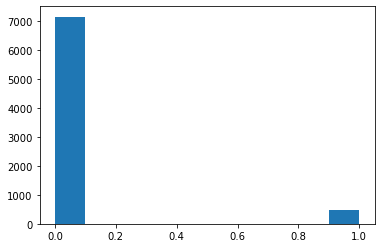

In [226]:
plt.hist(y_hat)

In [227]:
final_metric.metric(y_hat, y_train)

0.1697911087305838

In [197]:
text

id
3796     so you have a new weapon that can cause un ima...
3185     the f  amp  ing things i do for  gishwhes just...
7769     dt  georgegalloway  rt     ûïthe col police c...
191      aftershock back to school kick off was great  ...
9810     in response to trauma children of addicts deve...
                               ...                        
7470        there aren t many obliteration servers but ...
7691     just had a panic attack bc i don t have enough...
1242     omron hem   automatic blood pressure monitor s...
10862    officials say a quarantine is in place at an a...
10409    i moved to england five years ago today  what ...
Name: text, Length: 7613, dtype: object

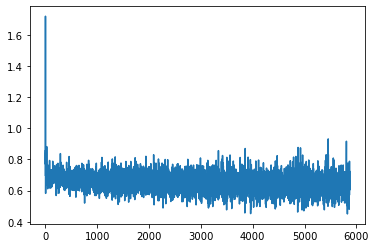

In [130]:
plt.plot(all_loss)

In [ ]:
tokenized_text.apply(len).max()

In [ ]:
def train(dataset, model, args):
    global losses
    seq_len = args['sequence_length']
    model.train()

    dataloader = DataLoader(dataset, batch_size=args['batch_size'], shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    for epoch in range(args['max_epochs']):
        losses = []
        for batch, (massages, massage_lens) in enumerate(dataloader):
            #             state_h, state_c = model.init_state(seq_len)
            max_massage_len = max(massage_lens).item()
            total_loss = 0
            for m in range(max_massage_len):
                mask = massage_lens > m
                x, y = (
                    torch.tensor(massages[mask, m:(m + seq_len)], dtype=torch.long),
                    torch.tensor(massages[mask, m + seq_len], dtype=torch.long)
                )

                optimizer.zero_grad()

                y_pred, _states = model(x)
                loss = criterion(y_pred, y)

                for state_h, state_c in _states:
                    state_h = state_h.detach()
                    state_c = state_c.detach()

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
            losses.append(total_loss / max_massage_len)
            print({'epoch': epoch, 'batch': batch, 'loss': losses[-1]})


In [ ]:
# from modeling.model import Model
# from modeling.dataset import Dataset
# from modeling.train import train
# from modeling.tokenizer import tokenize_text

# tokenized_text = text.apply(tokenize_text)
# args = {
#     'max_epochs' : 5,
#     'batch_size' : 256,
#     'sequence_length' : 5,
#     'max_len' : 100,
    
# }

# dataset = Dataset(tokenized_text,**args)
# model = Model(dataset)

# train(dataset, model, args)
# # model.load_state_dict(state_dict)

## Fitting

In [ ]:
clf.fit(X_train,y_train)
y_train_pred_score = clf.predict_proba(X_train)[:, 1]
y_pred_score = clf.predict_proba(X_test)[:, 1]
th = 0.5

### Threshold choosing

In [ ]:
from sklearn.model_selection import cross_val_predict
from ds_utils.cv_utils import cross_val_predict_proba

xx_train, xx_val, yy_train, yy_val = train_test_split(X_train, y_train, train_size=0.7, shuffle=True)

clf.fit(xx_train,yy_train)
yy_val_pred_score = clf.predict_proba(xx_val)[:, 1]
th = final_metric.get_thresh(yy_val, yy_val_pred_score)
print(f'threshold changed to {th}')

yy_val_pred = (yy_val_pred_score > th).astype(int)
val_score = final_metric.metric(yy_val, yy_val_pred)

### predict

In [ ]:
y_pred = (y_pred_score > th).astype(int)
y_train_pred = (y_train_pred_score > th).astype(int)

# (Validation) Evaluation

In [ ]:
if VALIDATION:
    from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve
    import matplotlib.pyplot as plt
    print(f'train score:\t {final_metric.metric(y_train, y_train_pred)}')
    print(f'test score:\t {final_metric.metric(y_test, y_pred)}')
    plot_roc_curve(clf, X_train, y_train, name='train')
    plot_roc_curve(clf, X_test, y_test, name='val', ax = plt.gca())
    plot_precision_recall_curve(clf, X_train, y_train, name='train')
    plot_precision_recall_curve(clf, X_test, y_test, name='val', ax = plt.gca())
    plot_confusion_matrix(clf, X_test, y_test)

# (Pred) Submit Results

In [ ]:
def get_submissions(kaggle_api=kaggle_api):
    past_submissions = pd.DataFrame(kaggle_api.competitions_submissions_list(COMPETITION))
    while(past_submissions.iloc[0].status == 'pending'):
        past_submissions = pd.DataFrame(kaggle_api.competitions_submissions_list(COMPETITION))
    good_past_submissions = past_submissions[(~past_submissions['description'].isna()) & (past_submissions['description'] != '')]
    past_submissions_params  = good_past_submissions['description'].astype(str).apply(eval)
    for k in past_submissions_params.iloc[0].keys():
        past_submissions.loc[good_past_submissions.index, k] = past_submissions_params.loc[good_past_submissions.index].apply(lambda d: d[k])
    current_submission, past_submissions = past_submissions.iloc[0], past_submissions.iloc[1:]
    return current_submission, past_submissions

if not VALIDATION:
    import datetime
    import kaggle
    kaggle_api = kaggle.KaggleApi()
    kaggle_api.authenticate() 
    
    current_time = str(datetime.datetime.now())[:-7].replace(' ', '__').replace('-', '_').replace(':', '_')
    final_result = pd.Series(data = y_pred, index = test.index, name='target').to_frame()
    submission_path = RESULTS_DIR / f'results_{current_time}.csv'
    final_result.to_csv(submission_path)
    
    desc = str({
        "clf" : str(clf),
        "params" : clf.get_params(),
        "val_score" : val_score,
    })
    kaggle_api.competition_submit(submission_path, desc, KAGGLE_COMPETITION)
    current_submission, past_submissions = get_submissions()
    print(f'Current score: {current_submission["publicScore"]}')
    print(f'Best score so far: {past_submissions["publicScore"].max()}')
    print(f'Current val_score: {current_submission["val_score"]}')
    print(f'Best val_score so far: {past_submissions["val_score"].max()}')

In [ ]:
y_pred.sum(), y_pred.shape[0]

# Feature Importances

## feature_importances_

In [ ]:
clf.feature_importance(X_train.columns)

## shap

In [ ]:
explainer = shap.TreeExplainer(clf._base_clf, X_train)
shap_values = explainer.shap_values(X_test)

In [ ]:
idx = np.random.choice(X_test.shape[0], size = 1)
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx], link="logit")

In [ ]:
shap.summary_plot(shap_values, X_test)

# Error Analysis

In [ ]:
sns.distplot(y_pred_score[y_test==1], label = 'P')
sns.distplot(y_pred_score[y_test==0], label = 'N')
plt.legend()

In [ ]:
top_FP = y_test[y_test==0].iloc[np.argpartition(y_pred_score[y_test==0], -4)[-4:][::-1]].index.tolist()
top_FN = y_test[y_test==1].iloc[np.argpartition(y_pred_score[y_test==1], 4)[:4]].index.tolist()

In [ ]:
top_FP

In [ ]:
shap_values = {k: shap_values[idx,:] for idx, k in enumerate(X_test.index)}

In [ ]:
data.loc[top_FN]

In [ ]:
ididid = top_FN[0]

In [ ]:
data.loc[top_FN[1]].text

In [ ]:
X_test.loc[[top_FN[0]]]

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[top_FN[0]], X_test.loc[[top_FN[0]]], link="logit")